In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.io
import pandas as pd
import numpy as np
import mne

# 1. Data Loading


In [2]:
# read EEG .mat file and load
mat_file_path = './data/sp1s_aa_1000Hz.mat'
mat_data = scipy.io.loadmat(mat_file_path)

In [3]:
# Access EEG train feature data from the loaded .mat file
train_X = mat_data['x_train']
train_X.shape # time * channel * trials

(500, 28, 316)

In [4]:
# Access EEG test data from the loaded .mat file
test_X = mat_data['x_test']
test_X.shape # time * channel * trials

(500, 28, 100)

In [5]:
# Access EEG train label data from the loaded .mat file
train_y = mat_data['y_train']
train_y.shape # time * channel * trials

(1, 316)

# 2. Data Preprocessing


In [6]:
from utils.multi_raw import set_multiple_raw
from utils.fileIO import save_preprocessed_data, load_preprocessed_data

In [7]:
channel_names = ['F3', 'F1', 'Fz', 'F2', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'O1', 'O2']

In [8]:
# sample_rate = 1000
# # Create raws of all trials
# train_X_raws = set_multiple_raw(train_X, channel_names, sample_rate)

In [9]:
# from preprocessing.preprocess import EEGPreProcessor

# # Create an instance of EEGPreprocessor
# preprocessor = EEGPreProcessor(train_X_raws)

# b_freq = [0.01, 50.]
# s_freq = 500
# p_freq = 50

# # Perform preprocessing steps
# preprocessed_data = preprocessor.preprocess(b_freq, s_freq, p_freq)

# save_path = './save/train_X_500Hz.csv'
# save_preprocessed_data(preprocessed_data, save_path)


In [10]:
# fig = preprocessed_data[1].plot(n_channels=len(channel_names), show=True, scalings='auto')
# fig = preprocessed_data[1].compute_psd(fmax=100).plot(average=True, picks="data", exclude="bads", amplitude=False)

In [11]:
# temp = preprocessed_data[0].copy().filter(l_freq=b_freq[0], h_freq=50.)
# temp.info

In [12]:
# fig = temp.plot(n_channels=len(channel_names), show=True, scalings='auto')
# fig = temp.compute_psd(fmax=100).plot(average=True, picks="data", exclude="bads", amplitude=False)

In [13]:
# save_path = './save/train_X_500Hz.csv'
# save_preprocessed_data(preprocessed_data, save_path)

In [14]:
load_path = './save/train_X_500Hz.csv'
train_X_processed = load_preprocessed_data(load_path, len(channel_names))

In [15]:
train_y_processed = np.transpose(train_y)

In [16]:
print(f'Shape of X: {train_X_processed.shape} | Shape of y: {train_y_processed.shape}')
print(f'Trials: {train_X_processed.shape[0]}\nChannels: {train_X_processed.shape[1]}\nFeatures: {train_X_processed.shape[2]}')

Shape of X: (316, 28, 250) | Shape of y: (316, 1)
Trials: 316
Channels: 28
Features: 250


# 3. Feature Extraction

In [17]:
from scipy import signal
import scipy.stats as stats
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [18]:
from evaluation.evaluation_tools import evaluate_with_randomforest, evaluate_with_tsne

### Statistical Feature Extraction

In [19]:
# A function to extract statistical features from each epoch
def statistical_features(epoch_data):
    features = []
    
    # Example: Mean, Standard Deviation, Skewness, and Kurtosis
    features.append(np.mean(epoch_data, axis=1))
    features.append(np.std(epoch_data, axis=1))
    features.append(stats.skew(epoch_data, axis=1))
    features.append(stats.kurtosis(epoch_data, axis=1))
    
    # Add more statistical features as needed
    return np.concatenate(features)

In [20]:
# Extract features for each epoch
statistical_feature_matrix = np.array([statistical_features(trial) for trial in train_X_processed])

In [21]:
statistical_feature_matrix.shape

(316, 112)

### Wavelet Transform

In [22]:
# Define the wavelet transform function
def wavelet_transform(data, scales):
    wavelet_features = []
    channels = data.shape[0]
    for channel in range(channels):
        for scale in scales:
            # Apply continuous wavelet transform (CWT)
            wavelet_data = signal.cwt(data[channel, :], signal.morlet, [scale])

            # Extract features (e.g., mean, variance) from the wavelet coefficients
            wavelet_features.append(np.mean(np.abs(wavelet_data)))
            wavelet_features.append(np.var(np.abs(wavelet_data)))

    return np.array(wavelet_features)

In [23]:
scales = np.arange(1, 11)  # Adjust the range of scales based on your requirements

# Extract wavelet transform features for each epoch
wavelet_feature_matrix = np.array([wavelet_transform(trial, scales) for trial in train_X_processed])


In [24]:
wavelet_feature_matrix.shape

(316, 560)

### Blind Source Separation

In [25]:
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from mne.decoding import CSP

In [26]:
# def find_optimal_component(c_min, c_max, bss=None, X=None, y=None):
#     # Find the optimal number of components
#     scores = []
#     components_range = range(c_min, c_max)  # Adjust the range as needed
#     # Reshape the data to (n_samples, n_features)
#     reshaped_data = X.reshape(X.shape[0], -1)

#     for n_components in components_range:
#         if bss == 'pca':
#             pca = PCA(n_components=n_components)
#             feature_matrix = pca.fit_transform(reshaped_data)

#         if bss == 'ica':
#             ica = FastICA(n_components=n_components, random_state=42)
#             feature_matrix = ica.fit_transform(reshaped_data)
    
#         if bss == 'svd':
#             svd = TruncatedSVD(n_components=n_components, random_state=42)
#             feature_matrix = svd.fit_transform(reshaped_data)

#         if bss == 'csp':
#             csp = CSP(n_components=n_components, reg=None, log=None, norm_trace=False)
#             feature_matrix = csp.fit_transform(X, train_y.reshape(-1))

#         X_train = feature_matrix
#         y_train = y

#         scores.append(evaluate_with_randomforest(X_train, y_train, str(n_components), show=False))
        
#     optimal_n_components = components_range[np.argmax(scores)]

#     return optimal_n_components

### Blind Source Separation
#### - PCA (Principal Component Analysis)

In [27]:
# Reshape the data to (n_samples, n_features)
reshaped_data = train_X_processed.reshape(train_X_processed.shape[0], -1)
reshaped_data.shape

(316, 7000)

In [56]:
# pca_components = find_optimal_component(30, 50, bss='pca', X=train_X_processed, y=train_y.T.reshape(-1))

In [55]:
# Initialize PCA model
pca = PCA(n_components=49)

# Transform the data using the learned PCA components
pca_feature_matrix = pca.fit_transform(reshaped_data)

pca_feature_matrix.shape

(316, 49)

### Blind Source Separation
#### - ICA (Independent Component Analysis)

In [58]:
# ica_components = find_optimal_component(30, 50, bss='ica', X=train_X_processed, y=train_y.T.reshape(-1))

In [64]:
ica = FastICA(n_components=3, random_state=42)

ica_feature_matrix = ica.fit_transform(reshaped_data)

ica_feature_matrix.shape

(316, 3)

### Blind Source Separation
#### - SVD (Singular Value Decomposition)

In [65]:
# svd_components = find_optimal_component(30, 50, bss='svd', X=train_X_processed, y=train_y.T.reshape(-1))

In [66]:
svd = TruncatedSVD(n_components=43, random_state=42)
svd_feature_matrix = svd.fit_transform(reshaped_data)
svd_feature_matrix.shape

(316, 43)

### Blind Source Separation
#### - CSP (Common Spatial Pattern)

In [68]:
# # Define and apply CSP
# csp_components = find_optimal_component(10, 50, bss='csp', X=train_X_processed, y=train_y.T.reshape(-1))

In [69]:
csp = CSP(n_components=20, reg=None, log=None, norm_trace=False)
csp_feature_matrix = csp.fit_transform(train_X_processed, train_y.reshape(-1))
print(csp_feature_matrix.shape)

Computing rank from data with rank=None


    Using tolerance 1.7e+02 (2.2e-16 eps * 28 dim * 2.8e+16  max singular value)
    Estimated rank (mag): 27
    MAG: rank 27 computed from 28 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 28 -> 27
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e+02 (2.2e-16 eps * 28 dim * 2.7e+16  max singular value)
    Estimated rank (mag): 27
    MAG: rank 27 computed from 28 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 28 -> 27
Estimating covariance using EMPIRICAL
Done.
(316, 20)


# 4. Evaluation with T-SNE

In [36]:
from evaluation.evaluation_tools import evaluate_feature

### Run with Original Data

In [37]:
train_X_original = np.transpose(np.concatenate(train_X, axis=0))
train_y_original = np.transpose(train_y)

[Result of t-SNE]


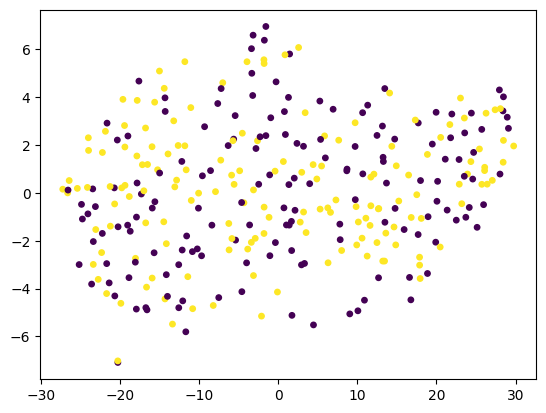

In [38]:
evaluate_with_tsne(train_X_original, train_y_original, 'Original Data')

Original Data Test Accuracy: 0.53
[Result of Random Forest]
Original Data Test Accuracy: 0.53


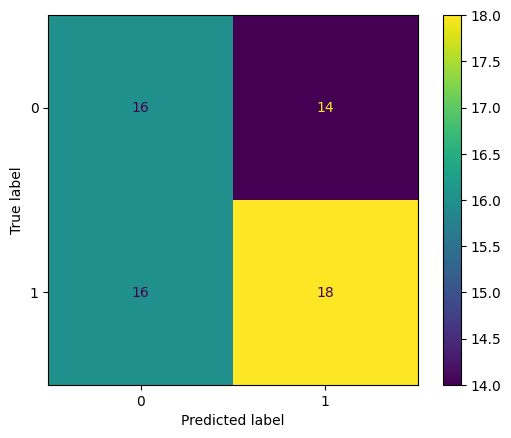

In [39]:
evaluate_with_randomforest(train_X_original, train_y_original, 'Original Data')

### Run with Statistical Feature

In [40]:
train_X_static = statistical_feature_matrix
train_y_static = np.transpose(train_y)

[Result of t-SNE]


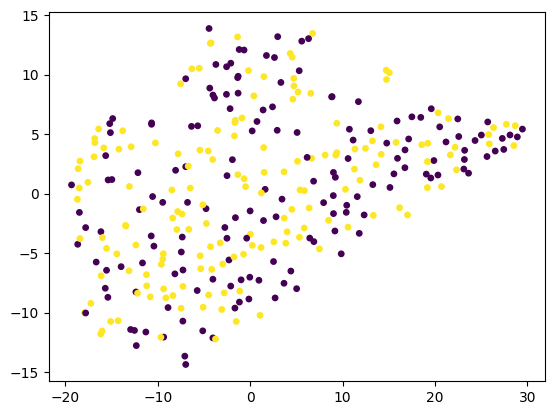

Statistical Feature Test Accuracy: 0.62
[Result of Random Forest]
Statistical Feature Test Accuracy: 0.62


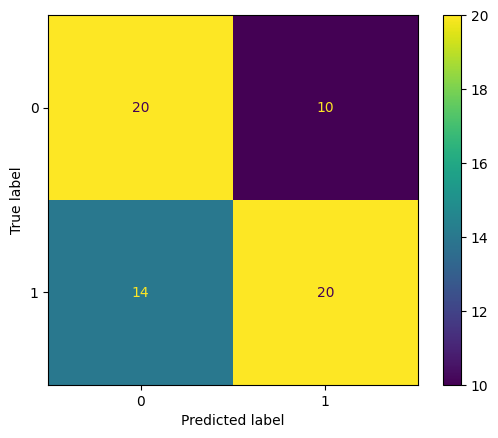

In [41]:
evaluate_feature(train_X_static, train_y_static, 'Statistical Feature')

### Run with Wavelet Transform


In [42]:
train_X_wav = wavelet_feature_matrix
train_y_wav = np.transpose(train_y)

[Result of t-SNE]


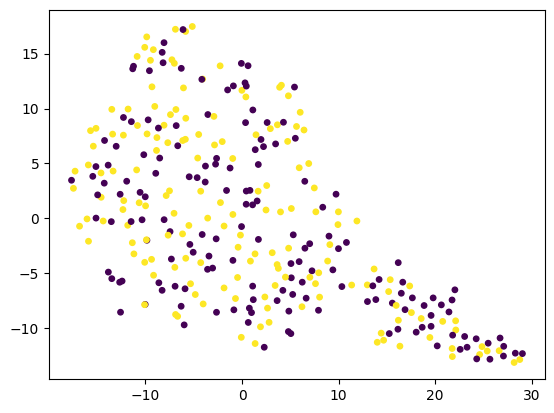

Wavelet Transform Test Accuracy: 0.69
[Result of Random Forest]
Wavelet Transform Test Accuracy: 0.69


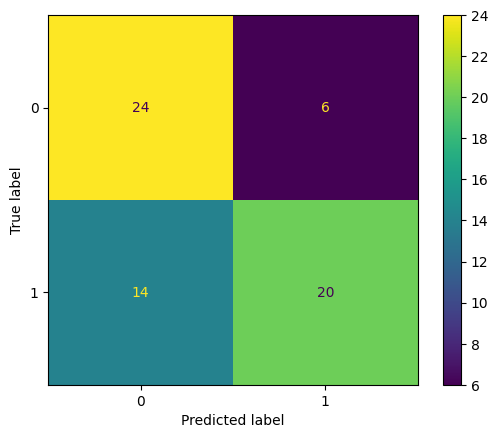

In [43]:
evaluate_feature(train_X_wav, train_y_wav, 'Wavelet Transform')

### Run with PCA

In [70]:
train_X_pca = pca_feature_matrix
train_y_pca = np.transpose(train_y)

[Result of t-SNE]


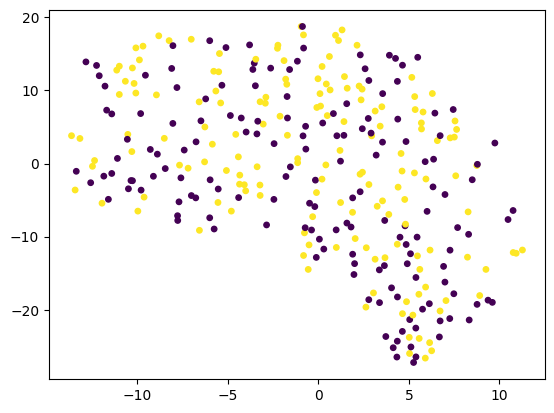

PCA Test Accuracy: 0.72
[Result of Random Forest]
PCA Test Accuracy: 0.72


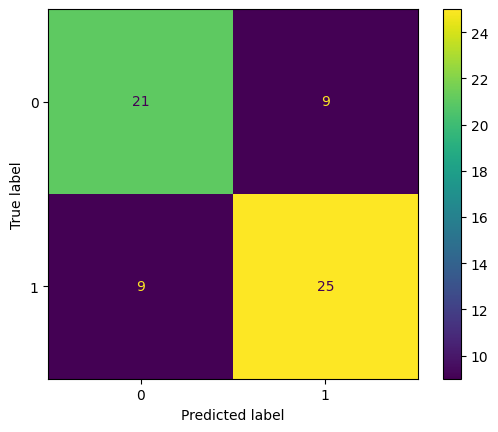

In [71]:
evaluate_feature(train_X_pca, train_y_pca, 'PCA')

### Run with ICA

In [72]:
train_X_ica = ica_feature_matrix
train_y_ica = np.transpose(train_y)

[Result of t-SNE]


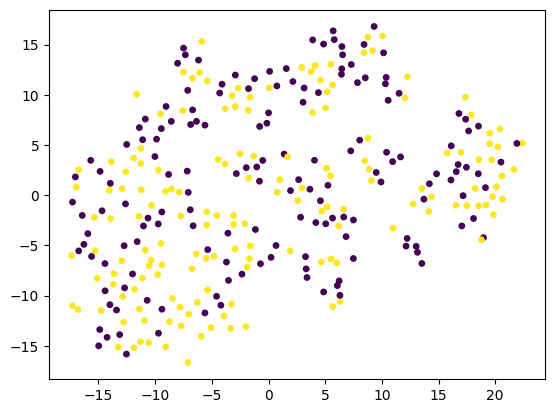

ICA Test Accuracy: 0.58
[Result of Random Forest]
ICA Test Accuracy: 0.58


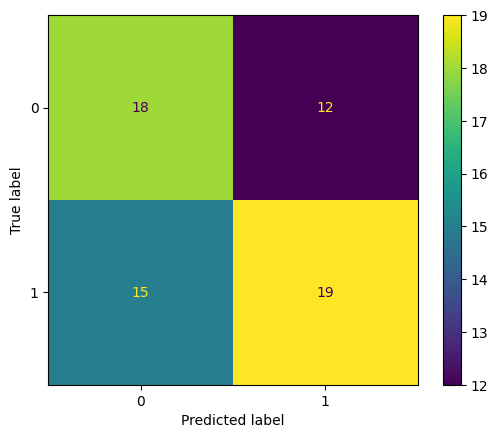

In [73]:
evaluate_feature(train_X_ica, train_y_ica, 'ICA')

### Run with SVD

In [74]:
train_X_svd = svd_feature_matrix
train_y_svd = np.transpose(train_y)

[Result of t-SNE]


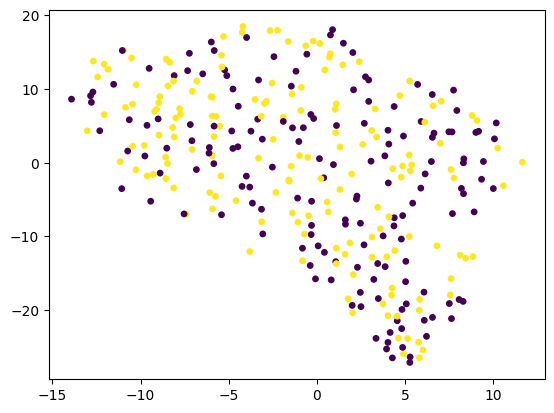

SVD Test Accuracy: 0.70
[Result of Random Forest]
SVD Test Accuracy: 0.70


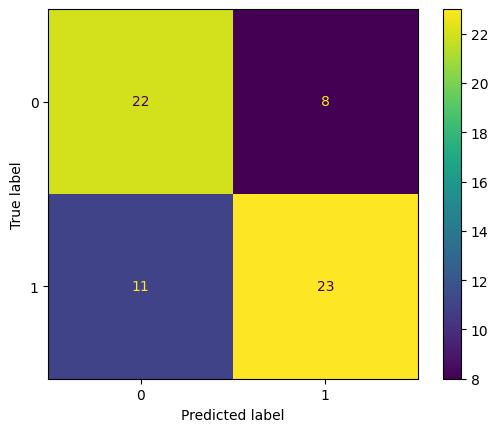

In [75]:
evaluate_feature(train_X_svd, train_y_svd, 'SVD')

### Run with PCA & ICA

In [76]:
train_X_PI = np.concatenate((pca_feature_matrix, ica_feature_matrix), axis=1)
train_y_PI = np.transpose(train_y)
train_X_PI.shape

(316, 52)

[Result of t-SNE]


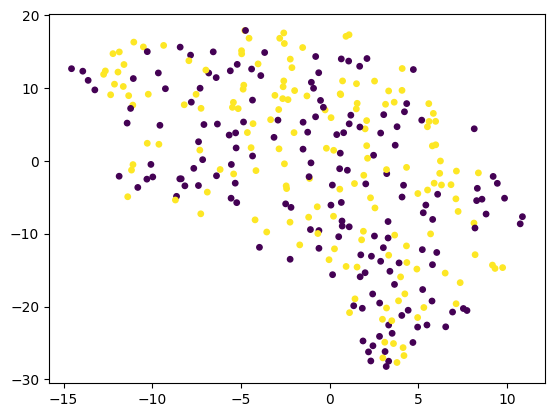

PCA & ICA Test Accuracy: 0.66
[Result of Random Forest]
PCA & ICA Test Accuracy: 0.66


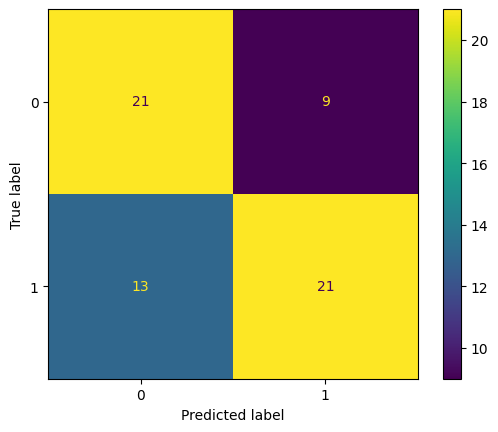

In [77]:
evaluate_feature(train_X_PI, train_y_PI, 'PCA & ICA')

### Run with CSP

In [78]:
train_X_csp = csp_feature_matrix
train_y_csp = np.transpose(train_y)

[Result of t-SNE]


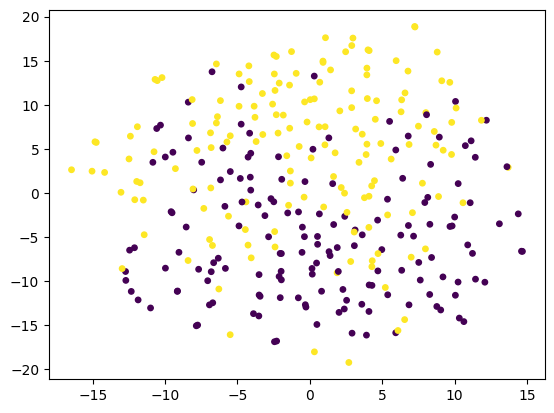

CSP Test Accuracy: 0.84
[Result of Random Forest]
CSP Test Accuracy: 0.84


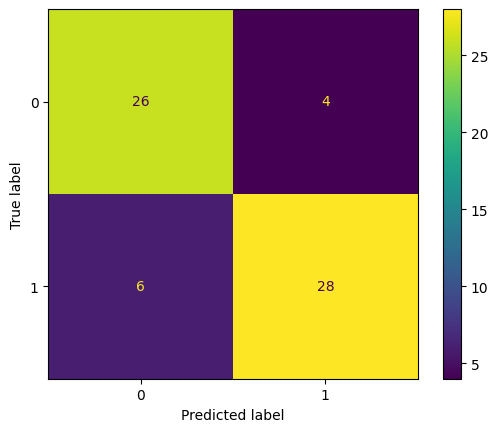

In [79]:
evaluate_feature(train_X_csp, train_y_csp, 'CSP')

In [54]:
## Validata the evaluation model(t-SNE, Random Forest)
# from sklearn import datasets

# # Data Load (MNIST: 64 dim)
# digits = datasets.load_digits()
# X = digits.data
# y = digits.target

# evaluate_with_tsne(X, y)
# evaluate_with_randomforest(X, y, 'MNIST')